Step 1: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Step 2: Define paths

In [ ]:
import os
from pathlib import Path

# Path where datasets are stored on Drive
base_dir = "/content/drive/MyDrive/skincare_project/raw_datasets"

# Define output root directory
output_root = Path("/content/drive/MyDrive/skincare_project/merged_skin_dataset")
images_dir = output_root / "images"
splits_dir = output_root / "splits"
models_dir = output_root / "models"
logs_dir = output_root / "logs"

# Create necessary directories
for d in [images_dir, splits_dir / "train", splits_dir / "val", splits_dir / "test", models_dir, logs_dir]:
    os.makedirs(d, exist_ok=True)


Step 3: Merge all datasets into /images/

This handles nested folders automatically.

In [ ]:
import shutil
from tqdm import tqdm

# All dataset folders
dataset_paths = [
    Path(base_dir) / "FaceSkinDiseases",
    Path(base_dir) / "Augmented Skin Conditions Image Dataset",
    Path(base_dir) / "Acne-Wrinkles-Spots-Classification",
    Path(base_dir) / "skin-disease-classification-dataset"
]

def copy_images(src_folder, dest_root):
    """
    Copies all images from src_folder (including nested ones)
    into dest_root/class_name.
    """
    for class_folder in src_folder.iterdir():
        if class_folder.is_dir():
            class_name = class_folder.name.strip().lower().replace(" ", "_")
            dest_folder = dest_root / class_name
            os.makedirs(dest_folder, exist_ok=True)

            # Recursively copy images (handles nested folders)
            for path in class_folder.rglob("*.*"):
                if path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    try:
                        shutil.copy(path, dest_folder / path.name)
                    except Exception as e:
                        print(f"Error copying {path}: {e}")

# Merge all datasets
for dataset_path in tqdm(dataset_paths, desc="Merging datasets"):
    copy_images(dataset_path, images_dir)

print("✅ All datasets merged into", images_dir)


Step 4: Split into Train/Val/Test

Now we’ll split all classes automatically.

In [ ]:
import random
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import os

random.seed(42)

for class_dir in tqdm(list(images_dir.iterdir()), desc="Splitting datasets"):
    if class_dir.is_dir():
        all_images = list(class_dir.glob("*.*"))
        n_images = len(all_images)

        if n_images < 5:
            # If too few images, keep them all in train
            split_folder = splits_dir / "train" / class_dir.name
            os.makedirs(split_folder, exist_ok=True)
            for img_path in all_images:
                shutil.copy(img_path, split_folder / img_path.name)
            print(f"⚠️ Skipped splitting '{class_dir.name}' (only {n_images} images, put in train only)")
            continue

        # Normal case
        train_imgs, temp_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for split_name, split_list in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
            split_folder = splits_dir / split_name / class_dir.name
            os.makedirs(split_folder, exist_ok=True)
            for img_path in split_list:
                shutil.copy(img_path, split_folder / img_path.name)


Step 5: Check the Folder Structure

In [ ]:
for root, dirs, files in os.walk(output_root):
    level = root.replace(str(output_root), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:3]:  # just show first 3 files for brevity
        print(f"{subindent}{f}")


merged_skin_dataset/
    images/
        rosacea/
            Rosacea_113.jpg
            Rosacea_111.jpg
            Rosacea_106.jpg
        basal_cell_carcinoma/
            basal-cell-carcinoma-nose-73.jpg
            basal-cell-carcinoma-nose-38.jpg
            basal-cell-carcinoma-face-13.jpg
        actinic_keratosis/
            actinic-keratosis-5FU-25.jpg
            actinic-keratosis-face-39.jpg
            actinic-keratosis-face-49.jpg
        eczemaa/
            eczema137.jpg
            eczema25.jpg
            eczema13.jpg
        acne/
            acne136.png
            acne103.png
            acne124.png
        milia/
            Milia_103.jpg
            Milia_1.jpg
            Milia_104.jpg
        eczema/
            Eczema_107.jpg
            Eczema_113.jpg
            Eczema_115.jpg
        carcinoma/
            Carcinoma_103.jpg
            Carcinoma_1.jpg
            Carcinoma_104.jpg
        keratosis/
            Keratosis_103.jpg
            Keratosis_102.

Step 6.1 — Imports + Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os


Step 6.2 — Define Paths

In [ ]:
base_path = "/content/drive/MyDrive/skincare_project/merged_skin_dataset/splits"

train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')


Step 6.2.1 — Clean Image Directories

Remove any non-image files that might interfere with the ImageDataGenerator.

In [ ]:
import os
from pathlib import Path

def clean_image_directories(base_dir):
    """Removes non-image files from directories."""
    allowed_extensions = {'.jpg', '.jpeg', '.png'}
    for root, _, files in os.walk(base_dir):
        for file in files:
            file_path = Path(root) / file
            if file_path.suffix.lower() not in allowed_extensions:
                print(f"Removing non-image file: {file_path}")
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Error removing file {file_path}: {e}")

print("Cleaning train directory...")
clean_image_directories(train_dir)
print("Cleaning validation directory...")
clean_image_directories(val_dir)
print("Cleaning test directory...")
clean_image_directories(test_dir)
print("Directory cleaning complete.")

Cleaning train directory...
Cleaning validation directory...
Cleaning test directory...
Directory cleaning complete.


Step 6.3 — Data Generators

We’ll use ImageDataGenerator to:

Load images in batches

Resize them to the same size (224×224)

Apply slight augmentation (rotation, zoom, flip, etc.)

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2913 images belonging to 13 classes.
Found 371 images belonging to 13 classes.
Found 375 images belonging to 13 classes.


Step 6.4 — Build Model (MobileNetV2)

We’ll use transfer learning — load a pre-trained MobileNetV2 and train only the top layers for your dataset.

In [ ]:
print("Train classes:", train_gen.num_classes)
print("Val classes:", val_gen.num_classes)
print("Test classes:", test_gen.num_classes)


Train classes: 13
Val classes: 13
Test classes: 13


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Step 6.5 — Training the Model

We’ll use:

EarlyStopping (to prevent overfitting)

ModelCheckpoint (to save the best model in /models folder)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/merged_skin_dataset/models/best_model.keras"

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 1030s 11s/step - accuracy: 0.4082 - loss: 1.9018 - val_accuracy: 0.6658 - val_loss: 0.9976
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 661ms/step - accuracy: 0.6337 - loss: 1.0694 - val_accuracy: 0.7143 - val_loss: 0.8434
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 673ms/step - accuracy: 0.6744 - loss: 0.9194 - val_accuracy: 0.7089 - val_loss: 0.8553
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 676ms/step - accuracy: 0.7083 - loss: 0.8150 - val_accuracy: 0.7439 - val_loss: 0.7684
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 673ms/step - accuracy: 0.7208 - loss: 0.7681 - val_accuracy: 0.7574 - val_loss: 0.7777
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 662ms/step - accuracy: 0.7365 - loss: 0.7527 - val_accuracy: 0.7655 - val_loss: 0.7351
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 670ms/step - accuracy: 0.7412 - loss: 0.6942 - val_accuracy: 0.7898 - val_loss: 0.7053
Epoch 8/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 655ms/step - accuracy: 0.7566 - loss: 0.6645 - val_accu

Step 6.2.2 — Verify Image Files

Check each file in the training, validation, and test directories to ensure they are valid images.

In [ ]:
from PIL import Image
import os

def verify_images(directory):
    """Verifies if files in a directory are valid images."""
    print(f"Verifying images in: {directory}")
    invalid_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify() # Verify the image data
            except (IOError, SyntaxError, Image.DecompressionBombError) as e:
                print(f"Invalid image file found: {file_path} - {e}")
                invalid_files.append(file_path)
            except Exception as e:
                print(f"An unexpected error occurred with file: {file_path} - {e}")
                invalid_files.append(file_path)
    return invalid_files

print("Verifying train directory...")
invalid_train_files = verify_images(train_dir)
print("\nVerifying validation directory...")
invalid_val_files = verify_images(val_dir)
print("\nVerifying test directory...")
invalid_test_files = verify_images(test_dir)

print("\n--- Verification Summary ---")
if not invalid_train_files and not invalid_val_files and not invalid_test_files:
    print("✅ All image files in train, validation, and test directories are valid.")
else:
    print("❌ Found invalid image files. Removing them now.")
    print(f"Invalid files in train: {len(invalid_train_files)}")
    print(f"Invalid files in validation: {len(invalid_val_files)}")
    print(f"Invalid files in test: {len(invalid_test_files)}")
    # Add code here to automatically remove these files
    for file_path in invalid_train_files + invalid_val_files + invalid_test_files:
        try:
            os.remove(file_path)
            print(f"Removed invalid file: {file_path}")
        except Exception as e:
            print(f"Error removing invalid file {file_path}: {e}")

Verifying train directory...
Verifying images in: /content/drive/MyDrive/skincare_project/merged_skin_dataset/splits/train

Verifying validation directory...
Verifying images in: /content/drive/MyDrive/skincare_project/merged_skin_dataset/splits/val

Verifying test directory...
Verifying images in: /content/drive/MyDrive/skincare_project/merged_skin_dataset/splits/test

--- Verification Summary ---
✅ All image files in train, validation, and test directories are valid.


Step 6.2.1 — Clean Image Directories

Remove any non-image files that might interfere with the ImageDataGenerator.

In [ ]:
import os
from pathlib import Path

def clean_image_directories(base_dir):
    """Removes non-image files from directories."""
    allowed_extensions = {'.jpg', '.jpeg', '.png'}
    for root, _, files in os.walk(base_dir):
        for file in files:
            file_path = Path(root) / file
            if file_path.suffix.lower() not in allowed_extensions:
                print(f"Removing non-image file: {file_path}")
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Error removing file {file_path}: {e}")

print("Cleaning train directory...")
clean_image_directories(train_dir)
print("Cleaning validation directory...")
clean_image_directories(val_dir)
print("Cleaning test directory...")
clean_image_directories(test_dir)
print("Directory cleaning complete.")

Cleaning train directory...
Cleaning validation directory...
Cleaning test directory...
Directory cleaning complete.


Step 6.6 — Evaluate on Test Data

In [ ]:
from tensorflow.keras.optimizers import Adam

for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 100s 853ms/step - accuracy: 0.4018 - loss: 2.2724 - val_accuracy: 0.7844 - val_loss: 0.7266
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 656ms/step - accuracy: 0.6034 - loss: 1.2519 - val_accuracy: 0.7493 - val_loss: 0.8413
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 649ms/step - accuracy: 0.6499 - loss: 1.0657 - val_accuracy: 0.7332 - val_loss: 0.8889
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 666ms/step - accuracy: 0.6804 - loss: 0.9315 - val_accuracy: 0.7305 - val_loss: 0.9644
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 669ms/step - accuracy: 0.6956 - loss: 0.8709 - val_accuracy: 0.7278 - val_loss: 0.9782
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 649ms/step - accuracy: 0.7505 - loss: 0.7452 - val_accuracy: 0.7412 - val_loss: 0.9357
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 669ms/step - accuracy: 0.7299 - loss: 0.7487 - val_accuracy: 0.7493 - val_loss: 0.8823
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 653ms/step - accuracy: 0.7596 - loss: 0.7040 - val_acc

Step 6.7 — Plot Accuracy and Loss Graphs

(Helps you visualize training progress)

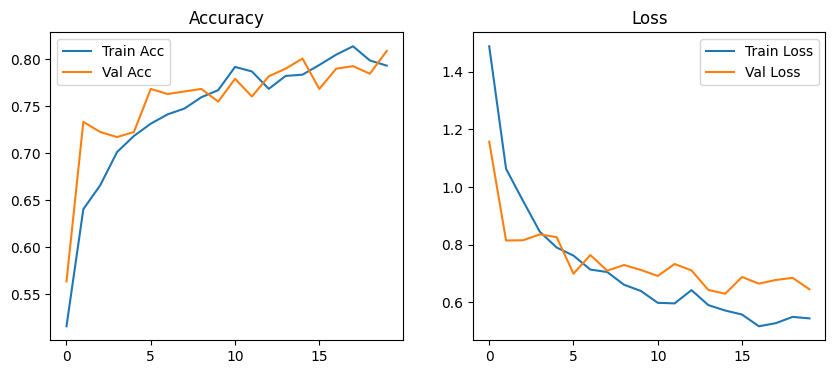

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


Step 6.8 — Save Final Model

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {test_acc * 100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 116s 10s/step - accuracy: 0.7975 - loss: 0.5841
✅ Final Test Accuracy: 77.07%


Step 6.9 — Predict on New Image (optional test)

You can test a random face to see which condition it detects:

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/skincare_project/sample_img.jpg"  # change this
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = np.argmax(pred)
class_label = list(train_gen.class_indices.keys())[class_idx]
print(f"Predicted Skin Condition: {class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Skin Condition: acne
